In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch

In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

In [3]:
from pts.model.tempflow import TempFlowEstimator
from pts.model.time_grad import TimeGradEstimator
from pts.model.transformer_tempflow import TransformerTempFlowEstimator
from pts import Trainer

/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

In [6]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']


In [7]:
# exchange_rate_nips, electricity_nips, traffic_nips, solar_nips, wiki-rolling_nips, ## taxi_30min is buggy still
dataset = get_dataset("electricity_nips", regenerate=False)

In [8]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='370')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [9]:
train_grouper = MultivariateGrouper(max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

In [10]:
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/dataset/multivariate_grou

In [11]:
estimator = TimeGradEstimator(
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length,
    cell_type='GRU',
    input_size=1484,
    freq=dataset.metadata.freq,
    loss_type='l2',
    scaling=True,
    diff_steps=100,
    beta_end=0.1,
    beta_schedule="linear",
    trainer=Trainer(device=device,
                    epochs=20,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=64,)
)

In [12]:
predictor = estimator.train(dataset_train, num_workers=8)

  0%|          | 0/99 [00:00<?, ?it/s]/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Time

In [13]:
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                                 predictor=predictor,
                                                 num_samples=100)

In [14]:
forecasts = list(forecast_it)
targets = list(ts_it)

/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/transform/feature.py:343:

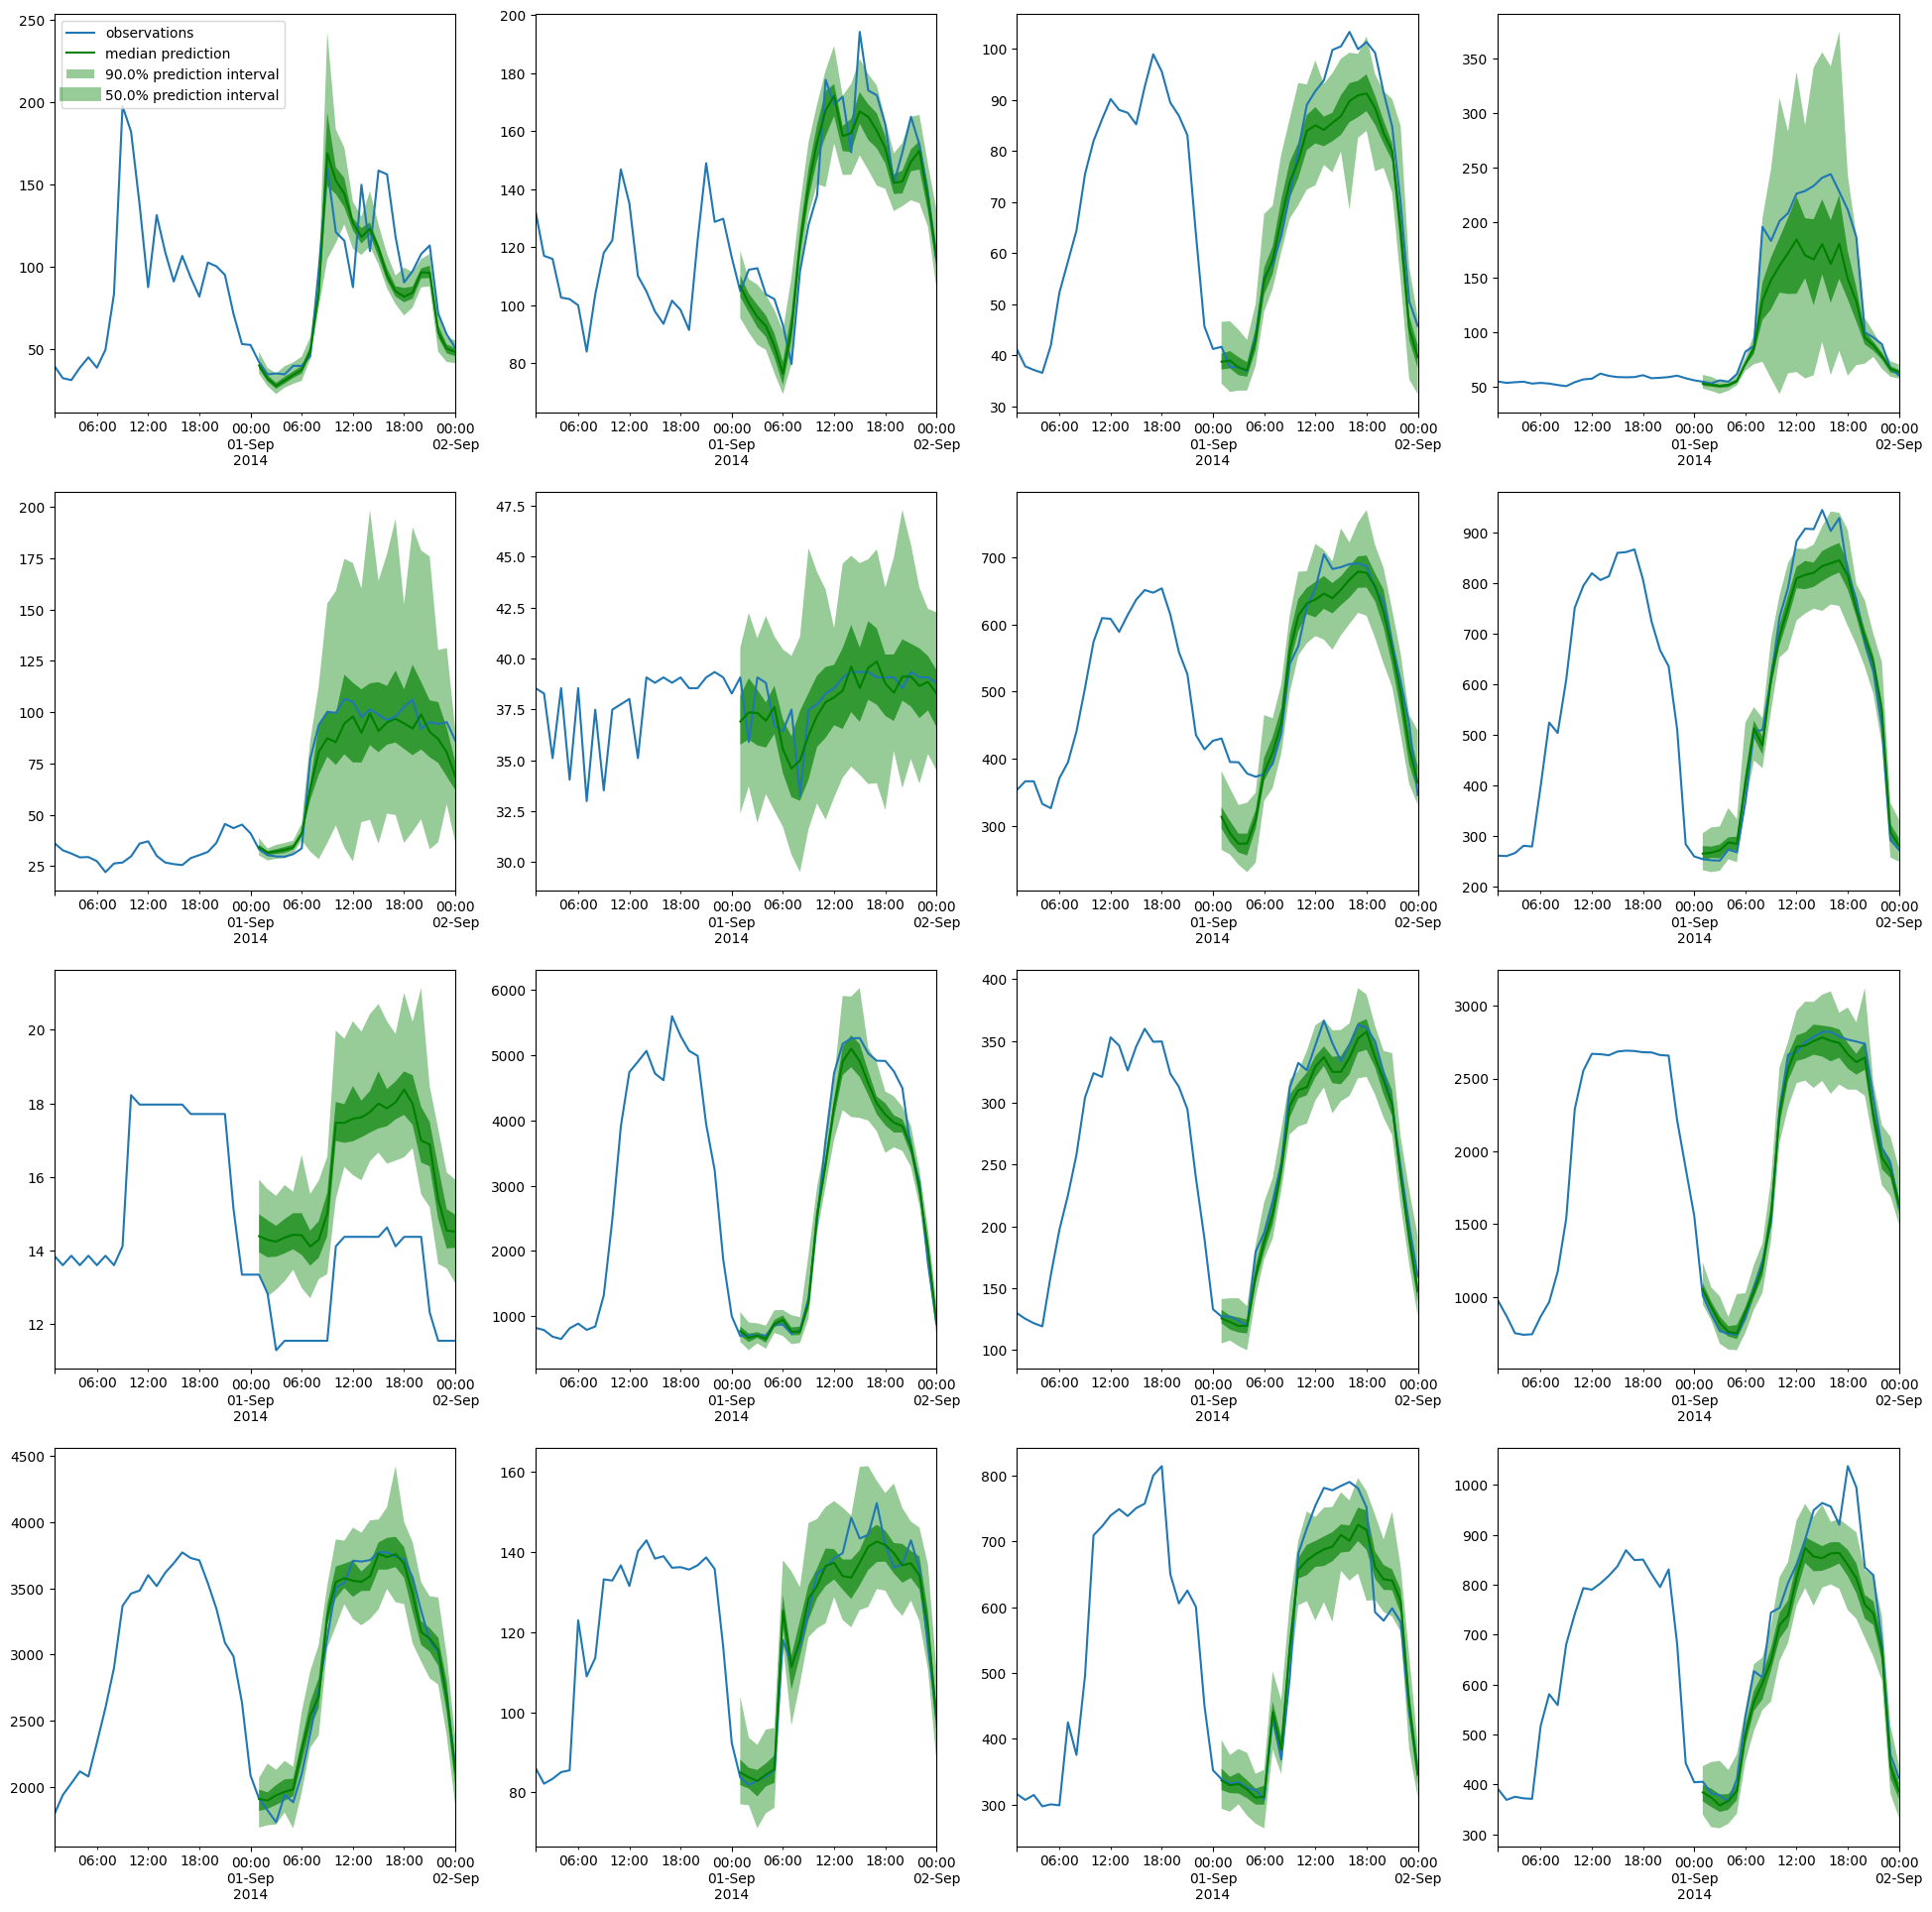

In [15]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()

In [16]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:], 
                                  target_agg_funcs={'sum': np.sum})

In [17]:
agg_metric, item_metrics = evaluator(targets, forecasts, num_series=len(dataset_test))

Running evaluation: 0it [00:00, ?it/s]/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/evaluation/_base.py:317: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 86.47it/s]
Running evaluation: 0it [00:00, ?it/s]/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/evaluation/_base.py:317: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 96.66it/s]
Running evaluation: 0it [00:00, ?it/s]/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/evaluation/_base.py:317: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 94.95it/s]
Running evaluation:

In [18]:
print("CRPS:", agg_metric["mean_wQuantileLoss"])
print("ND:", agg_metric["ND"])
print("NRMSE:", agg_metric["NRMSE"])
print("")
print("CRPS-Sum:", agg_metric["m_sum_mean_wQuantileLoss"])
print("ND-Sum:", agg_metric["m_sum_ND"])
print("NRMSE-Sum:", agg_metric["m_sum_NRMSE"])

CRPS: 0.051667358633620694
ND: 0.06529935523120177
NRMSE: 0.5376857007866181

CRPS-Sum: 0.020427887204801386
ND-Sum: 0.026942859654162245
NRMSE-Sum: 0.037070234369275645


In [19]:
# gradio ui establishment
import gradio as gr
import os
import pandas as pd
import matplotlib.pyplot as plt


def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows, cols = 4, 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape

    ps = [50.0] + [
        50.0 + f * c / 2.0 for c in prediction_intervals for f in (-1.0, +1.0)
    ]
    percentiles_sorted = sorted(set(ps))

    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3

    for dim in range(min(rows * cols, target_dim)):
        ax = axx[dim]
        target[-2 * prediction_length:, dim].plot(ax=ax)

        ps_data = [forecast.quantile(p / 100.0)[:, dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)

        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]
    axx[0].legend(legend, loc="upper left")

    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

    return fig

def preprocess_data(dataset):
    # 将一元时间序列“聚合”为多元输入
    train_grouper = MultivariateGrouper(
        max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality))
    )
    test_grouper = MultivariateGrouper(
        num_test_dates=int(len(dataset.test) / len(dataset.train)),
        max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality))
    )

    dataset_train = train_grouper(dataset.train)
    dataset_test = test_grouper(dataset.test)
    return dataset_train, dataset_test

def prediction(dataset_train, dataset_test):
    predictor = estimator.train(dataset_train, num_workers=8)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset_test,
        predictor=predictor,
        num_samples=100
    )
    forecasts = list(forecast_it)
    targets = list(ts_it)
    return forecasts, targets

def generate_plot(forecasts, targets, prediction_length):
    fig = plot(
        target=targets[0],
        forecast=forecasts[0],
        prediction_length=prediction_length,
    )
    return fig

def generate_text(forecasts):
    df = pd.DataFrame(forecasts)
    file_path = 'prediction_data.csv'
    df.to_csv(file_path, index=False)
    return file_path

def rnn_change(choice):
    estimator.cell_type = choice

def step_change(step):
    estimator.diff_steps = step

def lr_change(lr):
    estimator.trainer.learning_rate = lr

def epoch_change(epoch):
    estimator.trainer.epochs = epoch

def batchsize_change(batchsize):
    estimator.trainer.batch_size = batchsize

def prediction_length_change(prediction_length):
    estimator.prediction_length = int(prediction_length)

def beta_end_change(beta_end):
    estimator.beta_end = beta_end

def context_length_change(context_length):
    estimator.context_length = int(context_length)

def freq_change(freq):
    estimator.freq = freq

def load_user_data(file_obj):
    file_path = file_obj.name
    ext = os.path.splitext(file_path)[1].lower()
    if ext == '.csv':
        df = pd.read_csv(file_path)
    elif ext in ('.xls', '.xlsx'):
        df = pd.read_excel(file_path)
    elif ext == '.json':
        df = pd.read_json(file_path)
    else:
        raise ValueError(f"Unsupported file format: {ext}")
    return df

# 初始化 Estimator
dataset = get_dataset("electricity_nips", regenerate=False)
estimator = TimeGradEstimator(
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length,
    cell_type='GRU',
    input_size=1484,
    freq=dataset.metadata.freq,
    loss_type='l2',
    scaling=True,
    diff_steps=100,
    beta_end=0.1,
    beta_schedule="linear",
    trainer=Trainer(
        device='gpu',
        epochs=20,
        learning_rate=1e-3,
        num_batches_per_epoch=100,
        batch_size=64,
    )
)

def full_pipeline(file_obj, prediction_length):
    dataset = get_dataset("electricity_nips", regenerate=False)
    dataset_train, dataset_test = preprocess_data(dataset)
    forecasts, targets = prediction(dataset_train, dataset_test)
    fig = generate_plot(forecasts, targets, prediction_length)
    return fig

def full_pipeline_text(file_obj, prediction_length):
    df = load_user_data(file_obj)
    dataset_train, dataset_test = preprocess_data(dataset)
    forecasts, targets = prediction(dataset_train, dataset_test)
    text_book = generate_text(forecasts)
    return text_book

with gr.Blocks() as demo:
    with gr.Tab(label='TimeGrad'):
        with gr.Row():
            input_file = gr.File(label='Upload file')
            with gr.Column():
                generate_button = gr.Button('Generate')
            dropdown = gr.Dropdown(
                choices=['Image only', 'Image and Text'],
                label='Format'
            )

        gr.Markdown('## Diffusion model parameters')
        with gr.Row():
            dropdown_rnn = gr.Dropdown(choices=['LSTM', 'GRU'], label='RNN')
            dropdown_rnn.change(fn=rnn_change, inputs=dropdown_rnn, outputs=None)
            slider_step = gr.Slider(minimum=1, maximum=1000, step=10, label='Steps')
            slider_step.change(fn=step_change, inputs=slider_step, outputs=None)

        gr.Markdown('## Training parameters')
        with gr.Row():
            slider_lr = gr.Slider(minimum=1e-5, maximum=1e-2, step=1e-5, label='Learning rate')
            slider_lr.change(fn=lr_change, inputs=slider_lr, outputs=None)
            slider_epoch = gr.Slider(minimum=1, maximum=20, step=1, label='Training epochs')
            slider_epoch.change(fn=epoch_change, inputs=slider_epoch, outputs=None)

        with gr.Row():
            slider_batch = gr.Slider(minimum=1, maximum=128, step=1, label='Batch size')
            slider_batch.change(fn=batchsize_change, inputs=slider_batch, outputs=None)
            slider_beta_end = gr.Slider(minimum=1e-5, maximum=0.01, step=1e-5, label='beta_end')
            slider_beta_end.change(fn=beta_end_change, inputs=slider_beta_end, outputs=None)

        with gr.Row():
            text_pred_length = gr.Slider(minimum=1, maximum=1000, step=10, label='Prediction length')
            text_pred_length.change(fn=prediction_length_change, inputs=text_pred_length, outputs=None)
            text_ctx_length = gr.Slider(minimum=1, maximum=1000, step=10, label='Context length')
            text_ctx_length.change(fn=context_length_change, inputs=text_ctx_length, outputs=None)
            dropdown_freq = gr.Dropdown(choices=['D', 'H', 'M', 'S'], label='Frequency')
            dropdown_freq.change(fn=freq_change, inputs=dropdown_freq, outputs=None)

        prediction_img = gr.Plot()
        generate_button.click(
            fn=full_pipeline,
            inputs=[input_file, text_pred_length],
            outputs=prediction_img
        )

demo.launch(share=True, server_port=6006)

Running on local URL:  http://127.0.0.1:6006

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


IMPORTANT: You are using gradio version 3.48.0, however version 4.44.1 is available, please upgrade.
--------
